In [61]:
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dataseets
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torchvision.utils
import torch
from torch.autograd import variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
#from PIL import image
import PIL.ImageOps
import pandas as pd
import time
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from pytorch_metric_learning import losses, miners, samplers

In [34]:
t = transforms.Compose([
                       transforms.Resize((100,100)),
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0), std=(1))]
                       )

In [46]:
dataset = torchvision.datasets.LFWPeople(root = './LFW/', split = "train", download = True, transform = t)
dataset_test = torchvision.datasets.LFWPeople(root = './LFW/', split = "test", download = True, transform = t )

Files already downloaded and verified
Files already downloaded and verified


In [7]:
len(dataset)*10/100

952.5

In [36]:
dataset_train, dataset_val = torch.utils.data.random_split(dataset, [8573, 952])

In [245]:
label_train = []
label_val = []
label_test = []

for i in range(0,len(dataset_train)):
    label_train.append(dataset_train[i][1])
    
for i in range(0,len(dataset_val)):
    label_val.append(dataset_val[i][1])
    
for i in range(0,len(dataset_test)):
    label_test.append(dataset_test[i][1])

In [241]:
num_class_train = len(np.unique(label_train))
num_class_val = len(np.unique(label_val))
num_class_test = len(np.unique(label_test))

In [246]:
smpl_train  = samplers.MPerClassSampler(label_train, m=2, length_before_new_iter = len(dataset_train))
smpl_val    = samplers.MPerClassSampler(label_val, m=2, length_before_new_iter = len(dataset_val))
smpl_test   = samplers.MPerClassSampler(label_test, m=2, length_before_new_iter = len(dataset_test))

In [253]:
dataloader_train = DataLoader(dataset_train,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_train)

dataloader_val = DataLoader(dataset_val,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_val)

dataloader_test = DataLoader(dataset_test,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 2,
                              sampler = smpl_test)

example_batch = next(iter(dataloader_train))

[3837 3837 1630 1630 1190 1190 1788 1788 5300 5300 2071 2071 1307 1307
  896  896]


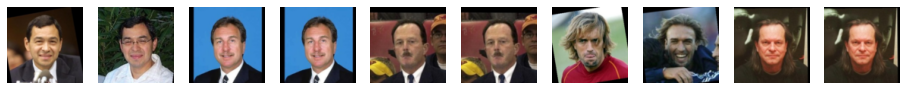

In [42]:
fig, ax = plt.subplots(1, 10, figsize = (16, 6))
for i in range(0, 10):
    ax[i].imshow(example_batch[0][i].permute(1,2,0))
    #ax[1][i].imshow(example_batch[1][i].permute(1,2,0))

    
for i in range(0, 10):
    ax[i].axis('off')
    #ax[1][i].axis('off')

print(example_batch[1].numpy().reshape(-1))

In [43]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.cnn1 = nn.Sequential(
        
            nn.Conv2d(3, 96, kernel_size = 11, stride = 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride = 2),
            
            nn.Conv2d(96, 256,kernel_size = 5, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
            
            nn.Conv2d(256, 384, kernel_size = 3, stride = 1),
            nn.ReLU(inplace = True)
        
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(384,1024),
            nn.ReLU(inplace = True),
        
            nn.Linear(1024, 512),
            nn.ReLU(inplace = True),
            
            nn.Linear(512, 256),
            nn.ReLU(inplace = True),
        
        )
        
        
    def forward(self, x):
        output = self.cnn1(x)
        #print(output.shape)
        #print("size:", output.view(output.size()[0],-1).shape)
        output = self.fc1(output.view(output.size()[0],-1))
        #print(output.shape)
        return output
    

In [44]:
net = Network().cuda()
criterion = losses.CircleLoss()
miner = miners.MultiSimilarityMiner()
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

In [45]:
iter_num = []

epoch_loss_train = []
epoch_loss_val = []

count = 0

len_train = len(dataloader_train)
len_val = len(dataloader_val)

since = time.time()

for epoch in range(100):
    #train
    total_loss = 0
    for i, (img, label) in enumerate(dataloader_train, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        loss.backward()
        
        optimizer.step()
        
        
        total_loss += loss.item()
    
    epoch_loss_train.append(total_loss/len_train)
    
    #validation
    total_loss_val = 0
    for j, (img, label) in enumerate(dataloader_val, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        #loss.backward()
        
        #optimizer.step()
        
        
        total_loss_val += loss.item()
    
    print(f"Epoch:{epoch} -> train loss:{total_loss/len_train} ,validation loss:{total_loss_val/len_val}")
    epoch_loss_val.append(total_loss_val/len_val)
time_elapsed = time.time() - since

Epoch:0 -> train loss:41.97496393399361 ,validation loss:45.018951416015625
Epoch:1 -> train loss:34.9657123781677 ,validation loss:41.046357997258504
Epoch:2 -> train loss:32.80019862835224 ,validation loss:40.95295483271281
Epoch:3 -> train loss:30.40186287399031 ,validation loss:35.898189608256025
Epoch:4 -> train loss:29.675816289380066 ,validation loss:35.276296838124594
Epoch:5 -> train loss:29.0241307458307 ,validation loss:32.03318007787069
Epoch:6 -> train loss:28.06846892935598 ,validation loss:29.005095688501992
Epoch:7 -> train loss:27.350330291650234 ,validation loss:28.80326925913493
Epoch:8 -> train loss:27.06367841337481 ,validation loss:30.444269784291585
Epoch:9 -> train loss:26.042670828664406 ,validation loss:27.82632129987081
Epoch:10 -> train loss:25.28845579909463 ,validation loss:30.343631076812745
Epoch:11 -> train loss:24.545411044715816 ,validation loss:32.560967715581256
Epoch:12 -> train loss:23.565356517449402 ,validation loss:26.853222195307414
Epoch:13 -

In [50]:
time_elapsed / 60

53.810721170902255

In [ ]:
plt.title('Training loss of AE per Epoch ')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train' , 'validation']);

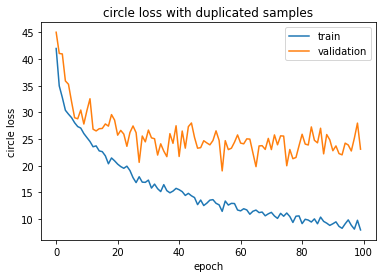

In [337]:
plt.plot(epoch_loss_train)
plt.plot(epoch_loss_val)
plt.title('circle loss with duplicated samples')
plt.ylabel('circle loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation']);

In [314]:
dataiter = iter(dataloader_test)
x1, l1 = next(dataiter)

In [315]:
dataiter = iter(dataloader_test)
x2, l2 = next(dataiter)

tensor([1.3349], device='cuda:0', grad_fn=<NormBackward1>)


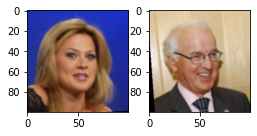

In [316]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net(x1[0].unsqueeze(0).cuda())
output2 = net(x2[0].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)

ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x2[0].permute(1,2,0))
print(euclidean_distance)

tensor([1.6000e-05], device='cuda:0', grad_fn=<NormBackward1>)


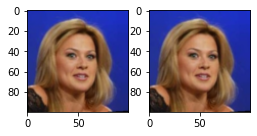

In [317]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net(x1[0].unsqueeze(0).cuda())
output2 = net(x1[1].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)


ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x1[1].permute(1,2,0))
print(euclidean_distance)

Part2: only classes with more than 2 samples

In [174]:
def key_func(dataset, s_count = 1):
    
    key = []
    
    targets = [s[1] for s in dataset]
    d = dict(Counter(targets))
    for i in d:
        if d[i]>s_count:
            key.append(i)    
    return key

In [176]:
def new_dataset(dataset):
    img_d = []
    label_d = []
    key = key_func(dataset)
    for img,l in dataset:
        if l in key: 
            img_d.append(img)
            label_d.append(l)
    d_new = list(zip(img_d,label_d))
    return d_new
    

In [178]:
train_dataset_2 = new_dataset(dataset_train)
val_dataset_2   = new_dataset(dataset_val)
test_dataset_2  = new_dataset(dataset_test)

In [204]:
def label_func(dataset):
    targets = [s[1] for s in dataset]
    return targets

In [205]:
train_label_2 = label_func(train_dataset_2)
val_label_2   = label_func(val_dataset_2)
test_label_2  = label_func(test_dataset_2)

In [302]:
smpl_train_2  = samplers.MPerClassSampler(train_label_2, m=2, length_before_new_iter = len(train_label_2))
smpl_val_2    = samplers.MPerClassSampler(val_label_2,   m=2, length_before_new_iter = len(val_label_2))
smpl_test_2   = samplers.MPerClassSampler(test_label_2,   m=2, length_before_new_iter = len(test_label_2))

In [303]:
dataloader_train_2 = DataLoader(train_dataset_2,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_train_2)

dataloader_val_2 = DataLoader(val_dataset_2,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 16,
                              sampler = smpl_val_2)

dataloader_test_2 = DataLoader(test_dataset_2,
                              shuffle = False,
                              num_workers = 0,
                              batch_size = 4,
                              sampler = smpl_test_2)

example_batch = next(iter(dataloader_train_2))

[1283 1283 4652 4652 4671 4671 2783 2783  408  408 1225 1225 3993 3993
 4595 4595]


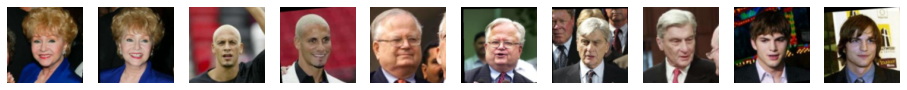

In [211]:
fig, ax = plt.subplots(1, 10, figsize = (16, 6))
for i in range(0, 10):
    ax[i].imshow(example_batch[0][i].permute(1,2,0))
    #ax[1][i].imshow(example_batch[1][i].permute(1,2,0))

    
for i in range(0, 10):
    ax[i].axis('off')
    #ax[1][i].axis('off')

print(example_batch[1].numpy().reshape(-1))

In [212]:
net_2 = Network().cuda()
criterion_2 = losses.CircleLoss()
miner_2 = miners.MultiSimilarityMiner()
optimizer_2 = optim.Adam(net.parameters(), lr = 0.0001)

In [213]:
epoch_loss_train_2 = []
epoch_loss_val_2 = []

count_2 = 0

len_train_2 = len(dataloader_train_2)
len_val_2 = len(dataloader_val_2)

since_2 = time.time()

for epoch in range(100):
    #train
    total_loss = 0
    for i, (img, label) in enumerate(dataloader_train_2, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer_2.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        loss.backward()
        
        optimizer.step()
        
        
        total_loss += loss.item()
    
    epoch_loss_train_2.append(total_loss/len_train_2)
    
    #validation
    total_loss_val = 0
    for j, (img, label) in enumerate(dataloader_val_2, 0):
        img, label = img.cuda().float(), label.cuda().float()

        optimizer_2.zero_grad()
        
        embedding = net(img)
        #print(embedding.shape)
        
        hard_pairs = miner(embedding,label)
        #print("hard_pairs", hard_pairs)
        
        loss = criterion(embedding, label, hard_pairs)
    
        #loss.backward()
        
        #optimizer.step()
        
        
        total_loss_val += loss.item()
    
    print(f"Epoch:{epoch} -> train loss:{total_loss/len_train_2} ,validation loss:{total_loss_val/len_val_2}")
    epoch_loss_val_2.append(total_loss_val/len_val_2)
time_elapsed_2 = time.time() - since_2

Epoch:0 -> train loss:16.96573921803678 ,validation loss:29.52903720310756
Epoch:1 -> train loss:15.990546615829182 ,validation loss:31.111992154802596
Epoch:2 -> train loss:16.990777187133105 ,validation loss:29.244479724339076
Epoch:3 -> train loss:15.687346701318406 ,validation loss:29.416252272469656
Epoch:4 -> train loss:13.45492481203115 ,validation loss:29.748623847961426
Epoch:5 -> train loss:14.784781977478485 ,validation loss:28.994216510227748
Epoch:6 -> train loss:14.24105261327622 ,validation loss:30.148518426077707
Epoch:7 -> train loss:12.930384271600273 ,validation loss:26.53958933694022
Epoch:8 -> train loss:14.59286016471377 ,validation loss:29.726258550371444
Epoch:9 -> train loss:14.34068314055825 ,validation loss:27.226532527378627
Epoch:10 -> train loss:14.016025893250655 ,validation loss:26.918079784938268
Epoch:11 -> train loss:12.08344913868422 ,validation loss:28.534139224461146
Epoch:12 -> train loss:13.037726523724388 ,validation loss:30.067097527640207
Epoc

In [214]:
time_elapsed_2 / 60

3.7370368162790935

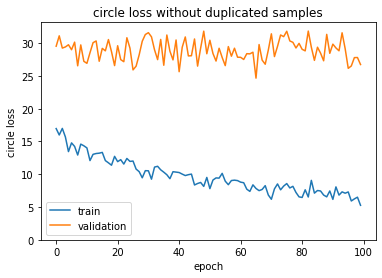

In [339]:
plt.plot(epoch_loss_train_2)
plt.plot(epoch_loss_val_2)
plt.ylim(ymin=0) 
plt.title('circle loss without duplicated samples')
plt.ylabel('circle loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation']);

In [323]:
dataiter = iter(dataloader_test_2)
x1, l1 = next(dataiter)

In [324]:
dataiter = iter(dataloader_test)
x2, l2 = next(dataiter)

tensor([0.0072], device='cuda:0', grad_fn=<NormBackward1>)


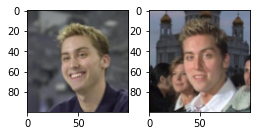

In [325]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net_2(x1[0].unsqueeze(0).cuda())
output2 = net_2(x1[1].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)

ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x1[1].permute(1,2,0))
print(euclidean_distance)

tensor([0.0105], device='cuda:0', grad_fn=<NormBackward1>)


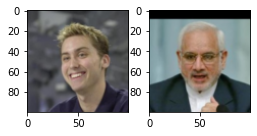

In [326]:
fig, ax = plt.subplots(1, 2, figsize = (4, 4))

output1 = net_2(x1[0].unsqueeze(0).cuda())
output2 = net_2(x2[1].unsqueeze(0).cuda())
euclidean_distance = F.pairwise_distance(output1, output2)

ax[0].imshow(x1[0].permute(1,2,0))
ax[1].imshow(x2[0].permute(1,2,0))
print(euclidean_distance)